# Mid Term Project: Salary Prediction

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

from functools import partial
from itertools import groupby

from sklearn.metrics            import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection    import train_test_split
from sklearn.tree               import DecisionTreeRegressor, export_text
from sklearn.ensemble           import RandomForestRegressor

import xgboost as xgb

%matplotlib inline

# EDA

In [2]:
!wget https://github.com/rfordatascience/tidytuesday/raw/master/data/2021/2021-05-18/survey.csv

--2021-11-02 00:21:46--  https://github.com/rfordatascience/tidytuesday/raw/master/data/2021/2021-05-18/survey.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-18/survey.csv [following]
--2021-11-02 00:21:46--  https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-18/survey.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5147731 (4.9M) [text/plain]
Saving to: ‘survey.csv.2’

survey.csv.2        100%[===================>]   4.91M  7.76MB/s    in 0.6s    

2021-11-02 00:21:47 (7.76 MB/s) - ‘survey.csv.2’ s

In [3]:
df_raw = pd.read_csv('survey.csv')
df_raw.timestamp = pd.to_datetime(df_raw.timestamp, format='%m/%d/%Y %H:%M:%S')
df_raw.dtypes

timestamp                                   datetime64[ns]
how_old_are_you                                     object
industry                                            object
job_title                                           object
additional_context_on_job_title                     object
annual_salary                                        int64
other_monetary_comp                                float64
currency                                            object
currency_other                                      object
additional_context_on_income                        object
country                                             object
state                                               object
city                                                object
overall_years_of_professional_experience            object
years_of_experience_in_field                        object
highest_level_of_education_completed                object
gender                                              obje

In [4]:
df_raw.head()

,timestamp,how_old_are_you,industry,job_title,additional_context_on_job_title,annual_salary,other_monetary_comp,currency,currency_other,additional_context_on_income,country,state,city,overall_years_of_professional_experience,years_of_experience_in_field,highest_level_of_education_completed,gender,race
0,2021-04-27 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000,0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,2021-04-27 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,54600,4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,2021-04-27 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000,NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,2021-04-27 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000,3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,2021-04-27 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000,7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


Looking through some key data to determine what is in the data set

In [5]:
df_raw.isnull().sum()

timestamp                                       0
how_old_are_you                                 0
industry                                       59
job_title                                       0
additional_context_on_job_title             19469
annual_salary                                   0
other_monetary_comp                          6785
currency                                        0
currency_other                              26066
additional_context_on_income                23360
country                                         0
state                                        4687
city                                           78
overall_years_of_professional_experience        0
years_of_experience_in_field                    0
highest_level_of_education_completed          196
gender                                        148
race                                          146
dtype: int64

In [6]:
df_raw.how_old_are_you.value_counts()

25-34         11748
35-44          9398
45-54          3042
18-24          1015
55-64           931
65 or over       88
under 18         10
Name: how_old_are_you, dtype: int64

In [7]:
df_raw.industry.value_counts()

Computing or Tech                       4360
Education (Higher Education)            2359
Nonprofits                              2331
Government and Public Administration    1821
Health care                             1739
                                        ... 
Aerospace/Aviation                         1
I work for Indeed.com                      1
Archives/Library Science                   1
Geospatial                                 1
Landscaping                                1
Name: industry, Length: 1068, dtype: int64

In [8]:
df_raw.job_title.value_counts()

Software Engineer                       289
Project Manager                         242
Director                                211
Senior Software Engineer                200
Executive Assistant                     171
                                       ... 
Events and Outreach Manager               1
Head of Circulation and Reference         1
Grant Advisor                             1
Coordinator, Marketing and Promotion      1
Knowledge Management Manager              1
Name: job_title, Length: 12622, dtype: int64

In [9]:
df_raw.country.value_counts()

United States                                            9010
USA                                                      7918
US                                                       2485
Canada                                                   1543
United Kingdom                                            584
                                                         ... 
Sri lanka                                                   1
Kuwait                                                      1
Eritrea                                                     1
For the United States government, but posted overseas       1
france                                                      1
Name: country, Length: 294, dtype: int64

In [10]:
df_raw.overall_years_of_professional_experience.value_counts()

11 - 20 years       9139
8 - 10 years        5041
5-7 years           4515
21 - 30 years       3470
2 - 4 years         2700
31 - 40 years        821
1 year or less       431
41 years or more     115
Name: overall_years_of_professional_experience, dtype: int64

In [11]:
df_raw.years_of_experience_in_field.value_counts()

11 - 20 years       6245
5-7 years           6114
2 - 4 years         5737
8 - 10 years        4701
21 - 30 years       1782
1 year or less      1249
31 - 40 years        366
41 years or more      38
Name: years_of_experience_in_field, dtype: int64

In [12]:
df_raw.highest_level_of_education_completed.value_counts()

College degree                        12584
Master's degree                        8387
Some college                           1880
PhD                                    1356
Professional degree (MD, JD, etc.)     1261
High School                             568
Name: highest_level_of_education_completed, dtype: int64

In [13]:
df_raw.gender.value_counts()

Woman                            20359
Man                               4743
Non-binary                         713
Other or prefer not to answer      268
Prefer not to answer                 1
Name: gender, dtype: int64

In [14]:
df_raw.race.value_counts()[:10]

White                                                     21909
Asian or Asian American                                    1217
Black or African American                                   618
Another option not listed here or prefer not to answer      566
Hispanic, Latino, or Spanish origin                         521
Hispanic, Latino, or Spanish origin, White                  351
Asian or Asian American, White                              327
Black or African American, White                            121
Middle Eastern or Northern African, White                    73
Native American or Alaska Native, White                      65
Name: race, dtype: int64

In [15]:
df_raw.annual_salary

0         55000
1         54600
2         34000
3         62000
4         60000
          ...  
26227     85000
26228     40000
26229    148000
26230     65000
26231    146192
Name: annual_salary, Length: 26232, dtype: int64

<AxesSubplot:xlabel='annual_salary', ylabel='Count'>

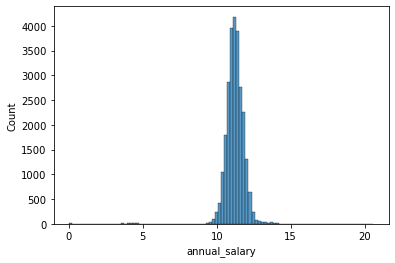

In [16]:
sns.histplot(np.log1p(df_raw.annual_salary),bins=100)

## Data wrangling

In [17]:
df_raw.dtypes

timestamp                                   datetime64[ns]
how_old_are_you                                     object
industry                                            object
job_title                                           object
additional_context_on_job_title                     object
annual_salary                                        int64
other_monetary_comp                                float64
currency                                            object
currency_other                                      object
additional_context_on_income                        object
country                                             object
state                                               object
city                                                object
overall_years_of_professional_experience            object
years_of_experience_in_field                        object
highest_level_of_education_completed                object
gender                                              obje

In [18]:
string_columns = df_raw.columns[(df_raw.dtypes == 'object')]
for col in string_columns:
    df_raw[col] = df_raw[col].str.lower().str.replace(' ','_')

In [19]:
df_raw = df_raw[~df_raw.industry.isnull()]
#Reducing the parameters required for us to fit somewhat
underrepresented_industries = df_raw.industry.value_counts()[(df_raw.industry.value_counts() == 1)].index.to_list()
df_raw.industry[df_raw.industry.isin(underrepresented_industries)] = 'other'

In [20]:
df_raw.highest_level_of_education_completed = df_raw.highest_level_of_education_completed.fillna('None')
df_raw.highest_level_of_education_completed.value_counts()

college_degree                        12557
master's_degree                        8372
some_college                           1873
phd                                    1354
professional_degree_(md,_jd,_etc.)     1260
high_school                             563
None                                    194
Name: highest_level_of_education_completed, dtype: int64

In [21]:
df_raw.gender = df_raw.gender.fillna('other_or_prefer_not_to_answer')
df_raw.gender[df_raw.gender == 'prefer_not_to_answer'] = 'other_or_prefer_not_to_answer'
df_raw.gender.value_counts()

/var/folders/ks/w_gw7dpd45xfmd1xm4cbg94r0000gn/T/ipykernel_9934/3467892078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw.gender[df_raw.gender == 'prefer_not_to_answer'] = 'other_or_prefer_not_to_answer'


woman                            20306
man                               4738
non-binary                         713
other_or_prefer_not_to_answer      416
Name: gender, dtype: int64

In [22]:
# Normalising country
df_raw.country[df_raw.country.isin(['united_states','usa','us','u.s.','united_states_of_america','united__states'])] = 'united_states'
df_raw.country[df_raw.country.isin(['uk','united_kingdom','england,_gb','england,_uk.','united_kindom','united_kingdom_(england)','wales_(united_kingdom)','u.k.','uk_(england)'])] = 'united_kingdom'
df_raw.country[df_raw.country.isin(['canada,_ottawa,_ontario'])] = 'canada'
df_raw.country.value_counts()

/var/folders/ks/w_gw7dpd45xfmd1xm4cbg94r0000gn/T/ipykernel_9934/1249477499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw.country[df_raw.country.isin(['united_states','usa','us','u.s.','united_states_of_america','united__states'])] = 'united_states'
/var/folders/ks/w_gw7dpd45xfmd1xm4cbg94r0000gn/T/ipykernel_9934/1249477499.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw.country[df_raw.country.isin(['uk','united_kingdom','england,_gb','england,_uk.','united_kindom','united_kingdom_(england)','wales_(united_kingdom)','u.k.','uk_(england)'])] = 'united_kingdom'
/var/folders/ks/w_gw7dpd45xfmd1xm4cbg9

united_states                                                             21430
canada                                                                     1569
united_kingdom                                                             1286
australia                                                                   369
germany                                                                     181
                                                                          ...  
new_zealand_aotearoa                                                          1
hartford                                                                      1
japan,_us_gov_position                                                        1
csnada                                                                        1
i_work_for_a_uae-based_organization,_though_i_am_personally_in_the_us.        1
Name: country, Length: 226, dtype: int64

In [23]:
# We really want to deal with total renumeration
df_raw.other_monetary_comp = df_raw.other_monetary_comp.fillna(0)
df_raw.currency_other = df_raw.currency_other.fillna(df_raw.currency)

df_raw = df_raw[df_raw.currency != 'other'].reset_index(drop=True)
df_raw.currency.value_counts()

usd        21805
cad         1561
gbp         1517
eur          582
aud/nzd      467
chf           35
sek           34
jpy           22
zar           13
hkd            4
Name: currency, dtype: int64

In [24]:
mismatched_currencies = df_raw[df_raw.currency_other != df_raw.currency] #Looking at this mostly misused
mismatched_currencies.head() #Can safely use just currency for everything

,timestamp,how_old_are_you,industry,job_title,additional_context_on_job_title,annual_salary,other_monetary_comp,currency,currency_other,additional_context_on_income,country,state,city,overall_years_of_professional_experience,years_of_experience_in_field,highest_level_of_education_completed,gender,race
748,2021-04-27 11:14:29,45-54,other,administrative_librarian,i_run_a_branch_library_and_am_responsible_for_...,76302,0.0,usd,"$76,302.34",NaN,united_states,arizona,glendale,21_-_30_years,21_-_30_years,master's_degree,woman,white
762,2021-04-27 11:14:39,25-34,recruitment_or_hr,lead_payroll_&_benefits_specialist,NaN,64000,6400.0,usd,my_bonus_is_based_on_performance_up_to_10%_of_...,NaN,united_states,new_york,schenectady,5-7_years,5-7_years,college_degree,woman,white
772,2021-04-27 11:14:45,45-54,education_(higher_education),sr_technical_support_rep,i,53000,0.0,usd,"i_work_for_an_online_state_university,_managin...","i_have_excellent_health_benefits,_time_off,_si...",united_states,new_jersey,trenton,8_-_10_years,2_-_4_years,master's_degree,woman,white
997,2021-04-27 11:18:27,35-44,recruitment_or_hr,hr_manager/accounts_payable,NaN,53500,0.0,usd,0,NaN,united_states,minnesota,minneapolis,11_-_20_years,2_-_4_years,college_degree,woman,white
1908,2021-04-27 11:34:43,35-44,education_(primary/secondary),instructional_coach,NaN,13560,0.0,usd,kwd,international_overseas_hires_also_get_flights_...,kuwait,NaN,hawalli,11_-_20_years,1_year_or_less,master's_degree,woman,white


In [25]:
df_raw.state = df_raw.state.fillna('na')
df_raw.state.value_counts()

na                         4554
california                 2429
new_york                   2038
massachusetts              1454
texas                      1169
                           ... 
nevada,_oregon                1
new_jersey,_virginia          1
montana,_wyoming              1
colorado,_massachusetts       1
oregon,_washington            1
Name: state, Length: 125, dtype: int64

In [26]:
df_raw.city = df_raw.city.fillna('none_supplied')
df_raw.city.value_counts()

boston                                                   802
new_york                                                 774
chicago                                                  773
seattle                                                  702
london                                                   596
                                                        ... 
too_small                                                  1
thornwood                                                  1
san_mateo,_ca                                              1
great_falls                                                1
na_(work_from_home_in_small_town,_decline_to_specify)      1
Name: city, Length: 3656, dtype: int64

In [27]:
df_raw.race = df_raw.race.fillna('another_option_not_listed_here_or_prefer_not_to_answer')
df_raw.race.value_counts()

white                                                                                                                            21802
asian_or_asian_american                                                                                                           1182
another_option_not_listed_here_or_prefer_not_to_answer                                                                             695
black_or_african_american                                                                                                          613
hispanic,_latino,_or_spanish_origin                                                                                                511
hispanic,_latino,_or_spanish_origin,_white                                                                                         344
asian_or_asian_american,_white                                                                                                     326
black_or_african_american,_white                       

In [28]:
# Convert currency to USD, as it's a small list just google exchange rates and apply dictionary map, and they won't be that out of date either
df_currency = pd.DataFrame({
    'CAD'     : 0.81
,   'GBP'     : 1.37
,   'EUR'     : 1.16
,   'AUD/NZD' : 0.74 #Rough average
,   'CHF'     : 1.10
,   'SEK'     : 0.12
,   'JPY'     : 0.0088
,   'ZAR'     : 0.065
,   'HKD'     : 0.13
}.items(),columns=['currency','exchange_rate'])
df_currency.currency = df_currency.currency.str.lower()

df = df_raw.merge(df_currency,on='currency')
df['renumeration'] = df.annual_salary + df.other_monetary_comp
df['renumeration']        = df['renumeration'] * df['exchange_rate']
df['annual_salary']       = df['annual_salary'] * df['exchange_rate']
df['other_monetary_comp'] = df['other_monetary_comp'] * df['exchange_rate']

In [29]:
del df['timestamp']
del df['currency']
del df['currency_other']
del df['additional_context_on_job_title']
del df['additional_context_on_income']
del df['exchange_rate']

In [30]:
categorical_columns = df.columns[df.dtypes=='object' ].values
numerical_columns   = df.columns[df.dtypes=='float64'].values
df.isnull().sum()

how_old_are_you                             0
industry                                    0
job_title                                   0
annual_salary                               0
other_monetary_comp                         0
country                                     0
state                                       0
city                                        0
overall_years_of_professional_experience    0
years_of_experience_in_field                0
highest_level_of_education_completed        0
gender                                      0
race                                        0
renumeration                                0
dtype: int64

## Feature Importance

As all our non-target variables are presented as categorical variables, before training we use mutual_info_score, using whether one is top 50% income, however we will get a better idea with training in model selection later

In [31]:
mutual_info_renumeration_score = partial(mutual_info_score,df.renumeration > np.median(df.renumeration))
df[categorical_columns].apply(mutual_info_renumeration_score).round(2).sort_values(ascending=False)

job_title                                   0.50
city                                        0.16
years_of_experience_in_field                0.07
industry                                    0.06
how_old_are_you                             0.04
country                                     0.04
overall_years_of_professional_experience    0.04
gender                                      0.02
highest_level_of_education_completed        0.01
state                                       0.00
race                                        0.00
dtype: float64

Job title is by far the most important element followed by city, years of experience in the field and industry. Neither state nor race were measurably important.

# Model Selection

We wish to compare random forrest and XGBoost to each other and determine one we'd like to use to fit price

## Setup training sets

In [32]:
prop_val   = 0.2
prop_test  = 0.2
prop_train = 1.0 - prop_test - prop_val
seed = 1

df_full_train, df_test = train_test_split(df           , test_size=prop_test                          , random_state=seed)
df_train, df_val       = train_test_split(df_full_train, test_size=prop_val / (prop_train + prop_test), random_state=seed)

def setup_tensors(df):
    df = df.reset_index(drop=True)
    y  = np.log1p(df.renumeration.values)
    for col in numerical_columns:
        del df[col]
    return df, y

df_full_train, y_full_train = setup_tensors(df_full_train)
df_train     , y_train      = setup_tensors(df_train     )
df_val       , y_val        = setup_tensors(df_val       )
df_test      , y_test       = setup_tensors(df_test      )

dv = DictVectorizer(sparse=False)
def transform_set(columns, df,fit=False):
    dicts = df[columns].to_dict(orient='records')
    if fit:
        X = dv.fit_transform(dicts)
    else:
        X = dv.transform(dicts)
    return dicts, X

fit_columns = categorical_columns
_               , _            = transform_set(fit_columns, df           , fit=True)
dicts_full_train, X_full_train = transform_set(fit_columns, df_full_train)
dicts_train     , X_train      = transform_set(fit_columns, df_train     )
dicts_val       , X_val        = transform_set(fit_columns, df_val       )
dicts_test      , X_test       = transform_set(fit_columns, df_test      )
dv.get_feature_names()

['city=(province_of_alberta)',
 'city=(rural)',
 'city=-',
 'city=--',
 'city=---',
 'city=/',
 'city=a_city_in_the_uk',
 'city=a_coruña',
 'city=a_large_city',
 'city=a_major_canadian_city',
 'city=aachen',
 'city=abbotsford',
 'city=aberdeen',
 'city=aberdeenshire',
 'city=adelaide',
 'city=adelaide,_south_australia',
 'city=airdrie',
 'city=alberta',
 'city=alice_springs',
 'city=alsace_(remote_to_paris)',
 'city=alton',
 'city=amsterdam',
 'city=amsterdsm',
 'city=antrim',
 'city=antwerp',
 'city=ardrossan',
 'city=arles',
 'city=ashford',
 'city=athens',
 'city=athlone',
 'city=auckland',
 'city=australia_not_sydney',
 'city=aylesbury',
 'city=badajoz',
 'city=baden-württemberg',
 'city=ballarat',
 'city=barcelona',
 'city=barrie',
 'city=barrie_ontario',
 'city=barxelona',
 'city=basel',
 'city=basingstoke',
 'city=bath',
 'city=bay_of_plenty',
 'city=bc',
 'city=bedford',
 'city=bedford,_uk',
 'city=bedfordshire',
 'city=belfast',
 'city=bergen',
 'city=berlin',
 'city=berlin,_g

We can look at the most important differentiating class by performing a stump fit

In [33]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- years_of_experience_in_field=2_-_4_years <= 0.50
|   |--- value: [11.13]
|--- years_of_experience_in_field=2_-_4_years >  0.50
|   |--- value: [10.79]



## Tune Random Forrest

In [34]:
def perform_random_forest_regressor(X,y,n_estimators=10, max_depth=None, random_state=1, n_jobs=-1):
    rfr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    rfr.fit(X, y)
    return rfr

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def calc_random_forest_regressor_error(X,y,X_t,y_t,**kwargs):
    rfr = perform_random_forest_regressor(X,y,**kwargs)
    y_pred = rfr.predict(X_t)
    return rmse(y_t,y_pred).round(3)

In [ ]:
errors = []
for max_depth in [5,7,10,15]:
    for n_estimator in range(10,201,10):
        error = calc_random_forest_regressor_error(X_train,y_train,X_val,y_val,n_estimators=n_estimator,max_depth=max_depth)
        errors.append({'n_estimator':n_estimator,'max_depth':max_depth, 'rmse':error})
df_errors = pd.DataFrame(errors)

In [ ]:
for max_depth in df_errors.max_depth.unique():
    df_subset = df_errors[df_errors.max_depth == max_depth]
    plt.plot( df_subset.n_estimator, df_subset.rmse, label='max_depth={}'.format(max_depth) )
plt.legend()

In [ ]:
max_depth_best = 7
n_estimator_best = 160

rfr = perform_random_forest_regressor(X_train,y_train,n_estimators=n_estimator_best,max_depth=max_depth_best)
importance = pd.DataFrame(list(zip(dv.get_feature_names(),rfr.feature_importances_)),columns=['feature_name','importance'])
importance.sort_values('importance',ascending=False).reset_index(drop=True).head(n=10)

This matches our test with the stump tree we constructed and is consistent with the mutual information tests we did earlier.

In [ ]:
y_pred = rfr.predict(X_val)
rmse(y_val,y_pred).round(3)

In [ ]:
sns.histplot(y_pred,label='predicted',bins=100)
sns.histplot(y_val ,label='actual'   ,bins=100)

## Tune XGBoost

In [ ]:
features = dv.get_feature_names()
dtrain   = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval     = xgb.DMatrix(X_val  , label=y_val  , feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = { 'max_depth':6, 'min_child_weight':1, 'objective':'reg:squarederror', 'nthread':2, 'seed':1, 'verbosity':1 }

def train_xgb(eta):
    xgb_params['eta'] = eta
    model = xgb.train(xgb_params, dtrain, num_boost_round=100,verbose_eval=5,evals=watchlist)
    return model

xgb_params

In [ ]:
%%capture output

for eta in [0.3,0.2,0.1,0.075, 0.05]:
    print('eta:{}'.format(eta))
    train_xgb(eta)

In [ ]:
s = output.stdout
# Create an iterator of program runs
def eta_iterator(s):
    lines = filter(lambda x: len(x),s.split('\n'))
    output_iter = (x[1] for x in groupby(lines, lambda line: line.startswith('eta')))
    for eta_header in output_iter:
        eta = float(eta_header.__next__().strip('eta:'))
        def _extract_line(line):
            it, train_rmse, val_rmse = line.split('\t')
            return { 'eta':eta
                   , 'it':it.strip('[]')
                   , 'train_rmse':float(train_rmse.split(':')[1])
                   , 'val_rmse':float(val_rmse.split(':')[1]) }
        yield( pd.DataFrame([ _extract_line(a) for a in output_iter.__next__()]) )
df_xgb = pd.concat(eta_iterator(s))

In [ ]:
for eta in df_xgb.eta.unique():
    df_subset = df_xgb[df_xgb.eta == eta]
    plt.plot(df_subset.it,df_subset.val_rmse,label='eta={}'.format(eta))
plt.legend()
plt.xlim(2,15)
eta_best = 0.2

In [ ]:
xgboost_best = train_xgb(eta_best)

In [ ]:
y_pred = xgboost_best.predict(dval)
rmse(y_val,y_pred).round(3)

In [ ]:
sns.histplot(y_pred,label='predicted',bins=100)
sns.histplot(y_val ,label='actual'   ,bins=100)

So our XGBoost model outperforms our random forrest model

# Tuned Model Evaulation

In [ ]:
dtrain_full = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
dtest       = xgb.DMatrix(X_test      , label=y_test      , feature_names=features)

watchlist = [(dtrain_full, 'full_train'), (dtest, 'test')]

xgb_params = { 'max_depth':6, 'min_child_weight':1, 'objective':'reg:squarederror', 'nthread':2, 'seed':1, 'verbosity':1 }

def train_xgb(eta):
    xgb_params['eta'] = eta
    model = xgb.train(xgb_params, dtrain_full, num_boost_round=100,verbose_eval=5,evals=watchlist)
    return model

xgboost_full_train = train_xgb(eta_best)

Even though we are training on more data, and we picked this model because the error was low on the validation data set, it is worse on the test data set. This means we have a very uncertain model, with not enough information to train.

In [ ]:
y_pred = xgboost_best.predict(dtest)
rmse(y_test,y_pred).round(3)

In [ ]:
sns.histplot(y_pred,label='predicted',bins=100)
sns.histplot(y_test,label='actual'   ,bins=100)